## Pre

In [1]:
%matplotlib inline

import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

import fastai.trainer
import fastai.utils2
import fastai.viz.image

from torchvision import transforms
import torch

In [2]:
reload(fastai.trainer)
reload(fastai.utils2)
reload(fastai.viz.image)

<module 'fastai.viz.image' from '/Users/pgollakota/code/fastaiverse/fastai/fastai/viz/image.py'>

In [3]:
# define various directory locations
data_dir = os.path.join(os.path.abspath(os.path.curdir), 'data/')
labels_path = data_dir + 'images/labels.csv'
image_dir = os.path.join(data_dir, 'images/train/')
thumb_dir = os.path.join(data_dir, 'thumbs/train/')
facets_dir = os.path.join(data_dir, 'facets/train/')

## Visualize class label distributions and images, split train & val

In [4]:
labels = pd.read_csv(labels_path)

In [5]:
labels.set_index('id', drop=False, inplace=True)

In [6]:
label_stats, label_plot = fastai.viz.image.visualize_classes(labels, 'breed')

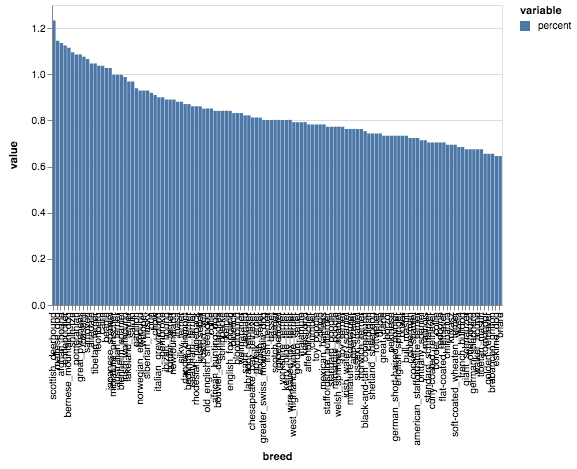

In [7]:
label_plot

In [8]:
#FIXME: Change api to train_test_split (a la sklearn)?
labels = fastai.utils2.preprocessing.split_train_valid(labels, 'id', 'breed', 0.2) 

In [9]:
%%time
labels, metadata_fpath, sprite_fpath  = fastai.viz.image.generate_facets_dive_data(
    labels, image_dir=image_dir, thumb_dir=thumb_dir, facets_dir=facets_dir)

HBox(children=(IntProgress(value=0, description='Generating and saving thumbnails', max=10222), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Creating sprite', max=10222), HTML(value='')))


CPU times: user 1min 26s, sys: 6.67 s, total: 1min 33s
Wall time: 1min 40s


In [10]:
#fastai.viz.image.display_facets_dive(metadata_fpath, sprite_fpath)

## Load Data

In [11]:
%%time
fastai.utils2.data.set_image_paths(labels, 'id', 'path', image_dir)

CPU times: user 8.6 s, sys: 145 ms, total: 8.75 s
Wall time: 8.98 s


In [12]:
#FIXME: Where are then numbers from?
mean_img = [0.485, 0.456, 0.406]
std_img = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean_img, std=std_img)

tfm = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
])
ds = fastai.utils2.data.ImageDataset(labels.loc[labels.loc[:, 'is_validation'] == True, :], 
                 'id', 'breed', 'path', root=image_dir, transform=tfm)
train_loader = torch.utils.data.DataLoader(
    ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

#sample_batch = next(iter(train_loader))
#denormed_img = denorm(z[0][30].numpy(), mean_img, std_img)
#plt.imshow(np.transpose(denormed_img, (1, 2, 0)))

## Fine Tune Model

In [13]:
# Trainer(model, dataloaders, optimizer=None, scheduler=None, criterion=None, callbacks=None, metrics=None)
# 1. Load model
# 2. Modify model as needed e.g. remove layers, add new layers, freeze layer (using the fine_tuner utilities for this)
# 3. Define the optimizer (for the modified model above)
# 4. Define the critierion for optimization
# 5. Create trainer with the modified model, optimizer and criterion
# 6. Train

In [14]:
from torch import nn, optim
from torchvision.models import resnet34

In [15]:
import fastai.fine_tuner
reload(fastai.fine_tuner)

<module 'fastai.fine_tuner' from '/Users/pgollakota/code/fastaiverse/fastai/fastai/fine_tuner.py'>

In [16]:
m = resnet34()

In [17]:
m2 = fastai.fine_tuner.pop_classifier(m)

In [18]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [19]:
from collections import OrderedDict

pooler = AdaptiveConcatPool2d()
classifier = nn.Sequential(
    fastai.trainer.Flatten(),
    nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True),
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=120, bias=True),
    nn.LogSoftmax(dim=1)
)

lyrs = OrderedDict([
    ('pooler', pooler),
    ('classifier', classifier)
])
m3 = fastai.fine_tuner.add_layers(m2, lyrs)

In [20]:
#m2 = fastai.fine_tuner.replace_classifier(m, nn.Linear(in_features=512, out_features=100, bias=True))

## Trainer

In [25]:
import fastai.trainer
reload(fastai.trainer)
import fastai.utils2.data
reload(fastai.utils2.data)

<module 'fastai.utils2.data' from '/Users/pgollakota/code/fastaiverse/fastai/fastai/utils2/data.py'>

In [26]:
mean_img = [0.485, 0.456, 0.406]
std_img = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(mean=mean_img, std=std_img)

tfm = transforms.Compose([
    transforms.transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

train_ds = fastai.utils2.data.ImageDataset(labels.loc[labels.loc[:, 'is_validation'] == False, :], 
                 'id', 'breed', 'path', root=image_dir, transform=tfm)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

val_ds = fastai.utils2.data.ImageDataset(labels.loc[labels.loc[:, 'is_validation'] == True, :], 
                 'id', 'breed', 'path', root=image_dir, transform=tfm)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=16, shuffle=False, num_workers=1, pin_memory=True)

opt = optim.SGD(m3.parameters(), lr = 0.01, momentum=0.9)
t = fastai.trainer.Trainer(m3, {'train': train_loader, 'val': val_loader}, optimizer=opt, criterion=nn.NLLLoss())

In [ ]:
t.fit(1)

HBox(children=(IntProgress(value=0, description='Epochs', max=1), HTML(value='')))

0


In [ ]:
z = next(res)

In [ ]:
z

In [ ]:
np.exp(z[0][0]) + np.exp(z[0][1])

In [ ]:
assert False

## Junk

In [ ]:
from torchvision.models import resnet34

model = resnet34()
# model.cuda()???
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss()

In [ ]:
from torchvision.models import resnet34
from tensorboardX import SummaryWriter
from torch.autograd import Variable

import torch
dummy_input = Variable(torch.rand(1, 3, 224, 224))
model = resnet34()
with SummaryWriter(comment='resnet34', log_dir='data/tensorboard/runs') as w:
    w.add_graph(model, (dummy_input, ))

In [ ]:
from fastai.dataset import ImageClassifierData
arch = resnet34
sz = 224
data = ImageClassifierData.from_csv(
    PATH,
    folder='images/train',
    csv_fname=PATH+'/images/train/labels.csv',
    tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

In [ ]:
model

In [ ]:
def get_val_index(labels_df):
    lbls = labels_df.sort_index().reset_index()
    return lbls[lbls.is_validation].index

In [ ]:
val_idxs = get_val_index(labels)

In [ ]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [ ]:
arch=resnet34

In [ ]:
sz=224

In [ ]:
tfms = tfms_from_model(arch, sz)

In [ ]:
inception_stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

In [ ]:
# Data loading code
import os
from torchvision import transforms
from torchvision import datasets
import torch
#from torch.utils.data import transforms
traindir = os.path.join(os.getcwd(), 'train')
valdir = os.path.join(os.getcwd(), 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

torchvision.models.resnet34(pretrained=True)

In [ ]:
val_idxs

In [ ]:
len(val_idxs)

In [ ]:
len(set(val_idxs))

In [ ]:
PATH

In [ ]:
data = ImageClassifierData.from_csv(PATH, PATH+'images/train', PATH+'images/train/labels.csv', val_idxs=val_idxs, suffix='.jpg', tfms=tfms)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.model

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(0.1, 5)

In [ ]:
learn.data.

In [ ]:
log_preds = learn.predict()

In [ ]:
log_preds

In [ ]:
len(data.val_y)

In [ ]:
data.classes[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
data.classes[85]

In [ ]:
log_preds.shape

In [ ]:
log_preds_df = pd.DataFrame(log_preds, columns=data.classes, 
                            index=[x.split('/')[-1].split('.')[0] for x in data.val_ds.fnames])

In [ ]:
log_preds_df

In [ ]:
nlargest = 3
order = np.argsort(-log_preds_df.values, axis=1)[:, :nlargest]

In [ ]:
order

In [ ]:
result = pd.DataFrame(log_preds_df.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=log_preds_df.index)

In [ ]:
result

In [ ]:
r = pd.merge(labels, result, left_index=True, right_index=True)

In [ ]:
(r.breed != r.top1).sum()

In [ ]:
382/2045

## Transfer learning

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = PATH
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Data Augmentation

In [ ]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [ ]:
data = ImageClassifierData.from_csv(PATH, PATH+'train', PATH+'labels.csv', val_idxs=val_idxs, test_name='test', suffix='.jpg', tfms=tfms)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(0.15, 5, cycle_len=1)

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([0.001,0.01,0.1])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
np.argmax(probs, 1)

In [ ]:
log_preds_test, y_test = learn.TTA(is_test=True)

In [ ]:
losses = []
for eps in [1e-6, 2e-6, 4e-6, 8e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 1e-4]:
    losses.append((eps, log_loss(np.array(learn.data.classes)[np.array(learn.data.val_ds.y)], probs, eps=eps)))

In [ ]:
losses

In [ ]:
probs_test = np.mean(np.exp(log_preds_test),0)

In [ ]:
probs_test.shape

In [ ]:
df = pd.DataFrame(probs_test, index=[x.split('/')[1].split('.')[0] for x in data.test_ds.fnames], columns = data.classes)

In [ ]:
df